<a href="https://colab.research.google.com/drive/1bE7aJedF2U-H_Byt_4vM8UQ4ZxHc3aji?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

# Image Classification with Vision Transformer and visualizations

Based on the Vision Transformer [ViT](https://arxiv.org/abs/2010.11929) keras code [code](https://github.com/keras-team/keras-io/blob/master/examples/vision/image_classification_with_vision_transformer.py)<br>


Added Visualization of the multi-head attention 
Article [Anatomy of the Beast with many heads](https://www.linkedin.com/pulse/anatomy-beast-many-heads-code-ibrahim-sobh-phd/)<br>

In [ ]:
!pip install -U tensorflow-addons 

     |████████████████████████████████| 679 kB 7.6 MB/s 


In [ ]:
import numpy as np
np.random.seed(1337)
import tensorflow as tf
tf.random.set_seed(1234)
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import imageio
import PIL
from PIL import Image, ImageDraw, ImageFont

In [ ]:
def make_video(movieName, img_list, att_list):
  with imageio.get_writer(movieName, mode='I') as writer:
      h,w = img_list[0].shape[0:2]
      for idx, img_i in enumerate(img_list): 
        canvas = PIL.Image.new('RGBA', (w*2, h), 'black')
        canvas.paste(Image.fromarray(img_list[idx].astype(np.uint8)), (0, 0))
        feature_map = Image.fromarray(att_list[idx].astype(np.uint8)) 
        canvas.paste(feature_map, (w, 0))
        writer.append_data(np.array(canvas))  

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 15 #100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4 #4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 1 #8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72 pixels
Patch size: 6 X 6 pixels
Patches per image: 144 (image_size // patch_size) ** 2
Elements per patch: 108 w*h*3


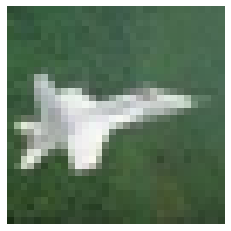

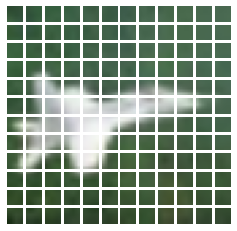

In [ ]:
plt.figure(figsize=(4, 4))
# image = x_train[np.random.choice(range(x_train.shape[0]))]

image = x_train[77]

plt.imshow(np.squeeze(image.astype("uint8")), cmap='gray')

plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size} pixels")
print(f"Patch size: {patch_size} X {patch_size} pixels")
print(f"Patches per image: {patches.shape[1]} (image_size // patch_size) ** 2")
print(f"Elements per patch: {patches.shape[-1]} w*h*3")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(np.squeeze(patch_img.numpy().astype("uint8")), cmap='gray')
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data. 
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # no pos encoding! 
    # encoded_patches = PatchEncoder2(num_patches, projection_dim)(patches)
    
    # Create multiple layers of the Transformer block.
    # attention_scores_list = []
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output, attention_scores_items = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1, return_attention_scores=True)
        # attention_scores_list.append(attention_scores_items)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)

    model_att = keras.Model(inputs=inputs, outputs=attention_scores_items)
    return model, model_att

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print("-"*50)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier, at_model = create_vit_classifier()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_1[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 108)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 144, 64)      16192       patches_1[0][0]                  
______________________________________________________________________________________________

In [ ]:
at_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_1[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 108)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 144, 64)      16192       patches_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
history = run_experiment(vit_classifier)

Epoch 1/15
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
176/176 [==============================] - 16s 65ms/step - loss: 2.0770 - accuracy: 0.3203 - top-5-accuracy: 0.8110 - val_loss: 1.5453 - val_accuracy: 0.4616 - val_top-5-accuracy: 0.9018
Epoch 2/15
176/176 [==============================] - 11s 63ms/step - loss: 1.5510 - accuracy: 0.4431 - top-5-accuracy: 0.8995 - val_loss: 1.2857 - val_accuracy: 0.5384 - val_top-5-accuracy: 0.9436
Epoch 3/15
176/176 [==============================] - 11s 64ms/step - loss: 1.3560 - accuracy: 0.5131 - top-5-accuracy: 0.9321 - val_loss: 1.1663 - val_accuracy: 0.5780 - val_top-5-accuracy: 0.9520
Epoch 4/15
176/176 [==============================] - 11s 65ms/step - loss: 1.2306 - accuracy: 0.5574 - top-5-accuracy: 0.9478 - val_loss: 1.0909 - val_accuracy: 0.6046 - val_top-5-accuracy: 0.9600
Epoch 5/15
176/176 [==============================] - 12s 66ms/step - 

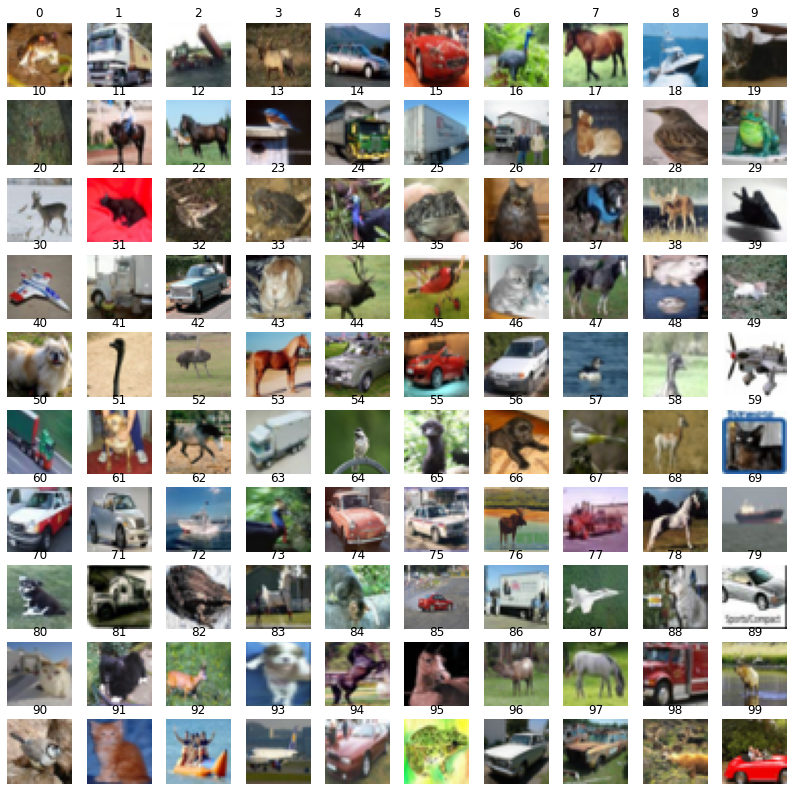

In [ ]:
plt.figure(figsize=(14, 14))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(np.squeeze(x_train[i]))
    plt.title(str(i))
    plt.axis("off")

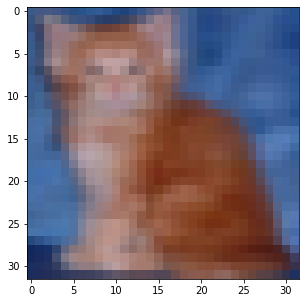

In [ ]:
selected_image_index = 91
plt.figure(figsize=(5, 5))
image = x_train[selected_image_index]
plt.imshow(np.squeeze(image))
plt.show()

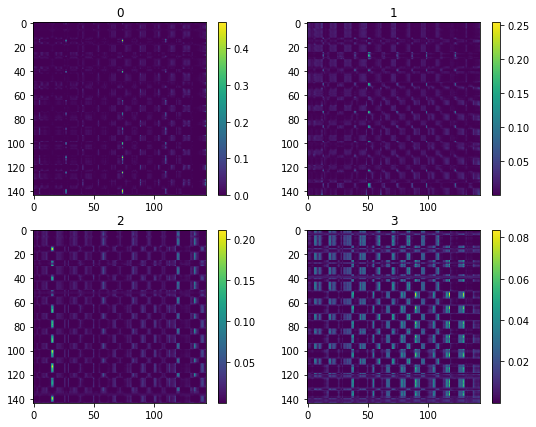

In [ ]:
plt.figure(figsize=(9, 7))
for h in range(4):
    ax = plt.subplot(2, 2, h + 1)
    att_results = at_model(np.expand_dims(x_train[selected_image_index], axis=0))
    plt.imshow(att_results[0,h,:])
    plt.title(str(h))
    plt.colorbar()

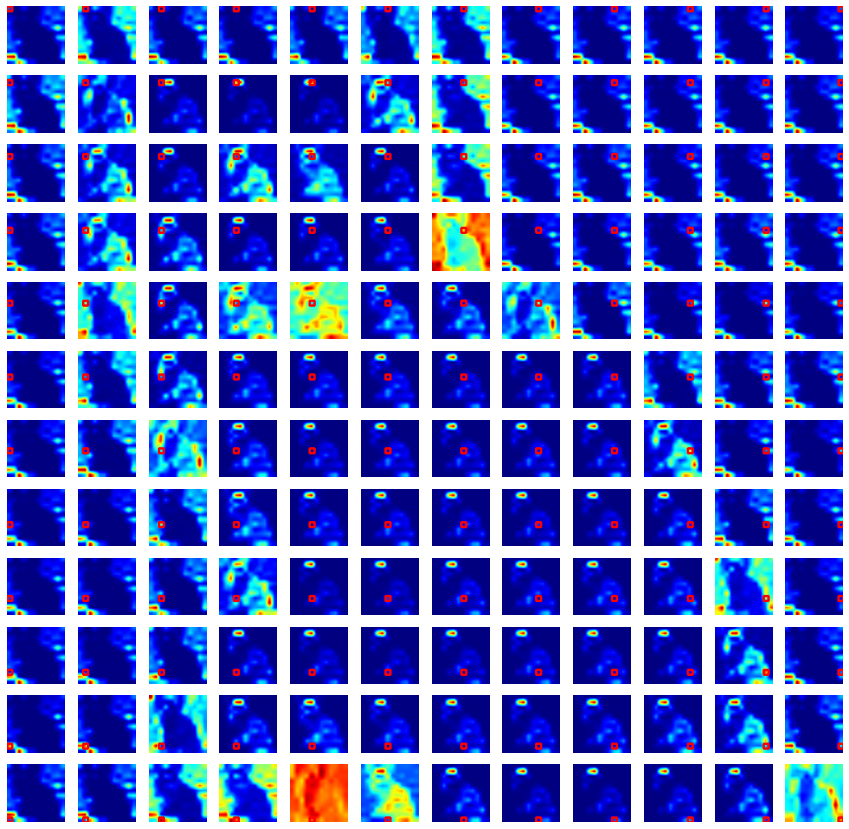

In [ ]:
head_index =  2
att_list = []
patch_list = []
std_list = []
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(15, 15))
for selected_q_index in range(n*n):
  ax = plt.subplot(n, n, selected_q_index + 1)
  
  att_mask  = tf.reshape(att_results[0, head_index, selected_q_index, :], [n, n])
  feature_map = att_mask.numpy()
  std_list.append(np.std(feature_map))
  feature_map /= np.max(feature_map)
  feature_map *= 255
  feature_map = np.clip(feature_map, 0, 255).astype('uint8')
  feature_map = cv2.resize(feature_map, (image_size, image_size))
  
  
  feature_map = cv2.applyColorMap(feature_map, cv2.COLORMAP_JET)
  feature_map = cv2.cvtColor(feature_map, cv2.COLOR_BGR2RGB)
  
  image_patch = cv2.resize(image, (image_size, image_size))
  n = int(np.sqrt(num_patches))
  x = selected_q_index % n
  y = selected_q_index // n 
  cv2.rectangle(feature_map, (x*patch_size, y*patch_size), ((x*patch_size)+patch_size, (y*patch_size)+patch_size), 255, 2)
  cv2.rectangle(image_patch, (x*patch_size, y*patch_size), ((x*patch_size)+patch_size, (y*patch_size)+patch_size), 255, 2)

  # feature_map = feature_map + (0.3 * image_patch).astype('uint8')
  # image_patch = image_patch + (0.3 * feature_map).astype('uint8')
  image_patch = cv2.addWeighted(image_patch,1.0,feature_map,0.2,0)
  att_list.append(feature_map)
  patch_list.append(image_patch)
  # cv2_imshow(feature_map)
  plt.imshow(feature_map)
  # plt.imshow(image_patch)
  #plt.imshow(image_patch, cmap='gray')
  # cv2_imshow(feature_map)
  plt.axis("off")   


In [ ]:
make_video('att_cifar_L1H1_91_h3.mp4', patch_list, att_list)